### Задание для курсового проекта

Ссылка: https://www.kaggle.com/competitions/real-estate-price-prediction-moscow

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle: dmitriicherepanov


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

**Подключение библиотек и скриптов**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime
from catboost import CatBoostRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [7]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [8]:
train_df.shape[1] - 1 == test_df.shape[1]

True

## 1. EDA  <a class='anchor' id='eda'>

**Целевая переменная**

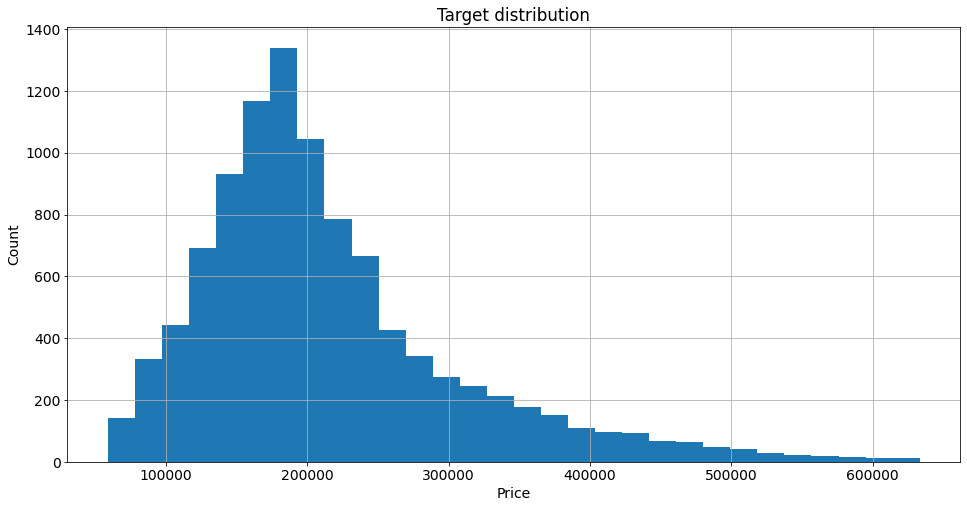

In [9]:
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [10]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

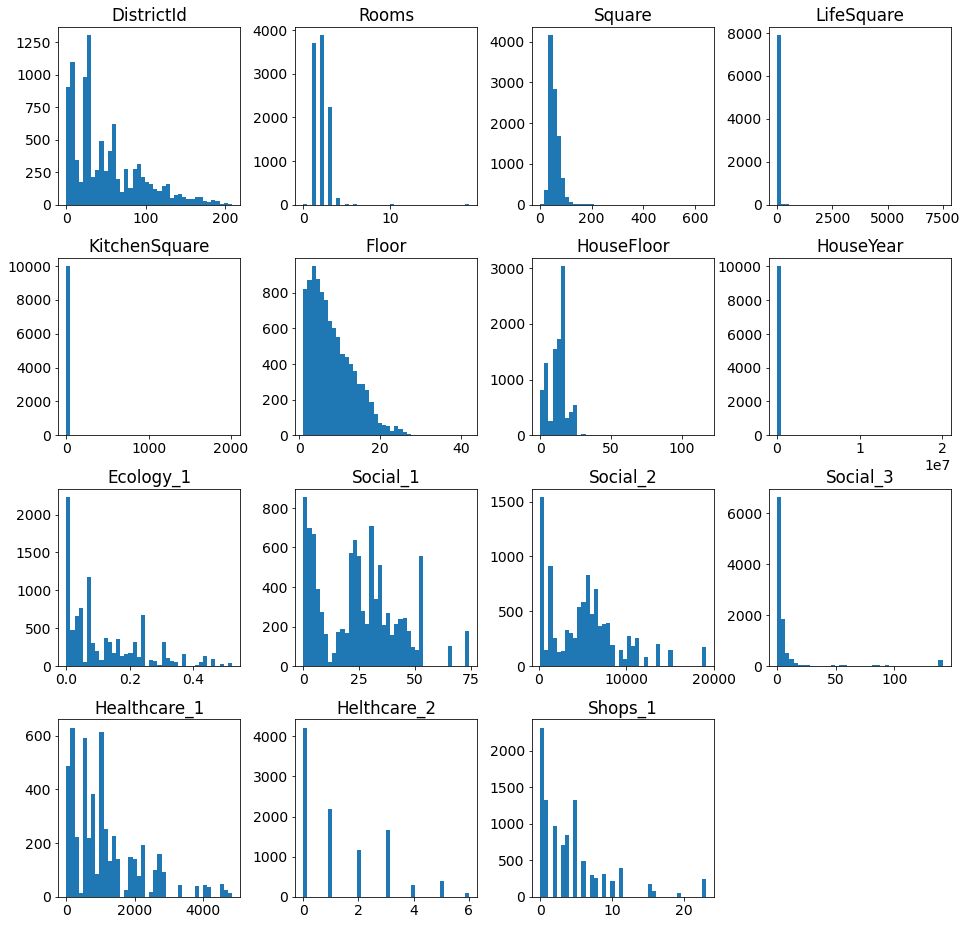

In [12]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features = df_num_features[df_num_features.columns[1:-1]]
df_num_features.hist(figsize=(16, 16), bins=40, grid=False)
plt.show()

**KitchenSquare**

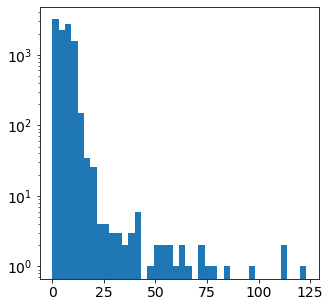

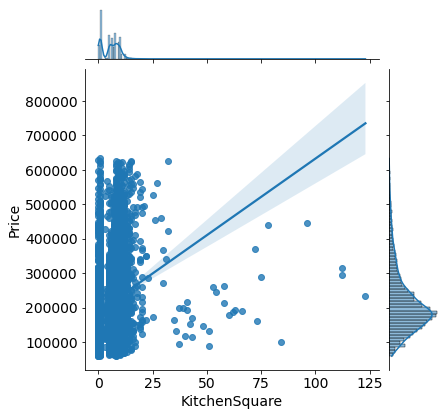

In [13]:
train_df.loc[train_df['KitchenSquare'] < 300, 'KitchenSquare'].hist(figsize=(5, 5), bins=40, grid=False)
plt.yscale('log')
train_df_kitchen = train_df.loc[train_df['KitchenSquare'] < 250]
grid = sns.jointplot(x=train_df_kitchen['KitchenSquare'], y=train_df_kitchen['Price'], kind='reg')
plt.show()

Доля квартир с площадью кухни больше 28 составляет менее 0.1%, поэтому заменим площадь кухни в таких квартирах на 28.

**LifeSquare**

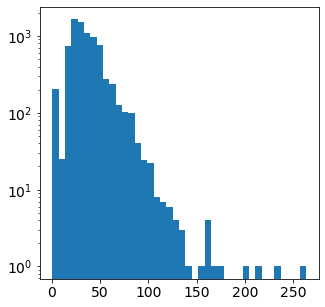

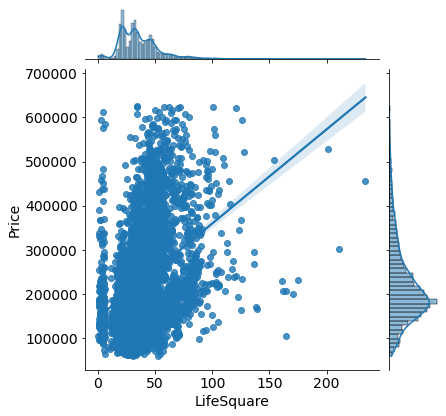

In [14]:
train_df.loc[train_df['LifeSquare'] < 300, 'LifeSquare'].hist(figsize=(5, 5), bins=40, grid=False)
plt.yscale('log')
train_df_life = train_df.loc[train_df['LifeSquare'] < 250]
grid = sns.jointplot(x=train_df_life['LifeSquare'], y=train_df_life['Price'], kind='reg')
plt.show()

Колонка LifeSquare имеет аналогичную проблему с выбросами, которую решим похожим образом: все, что больше 275, заменим на 275, а меньше 10 - на 10.

**Square**

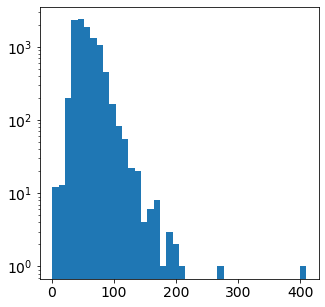

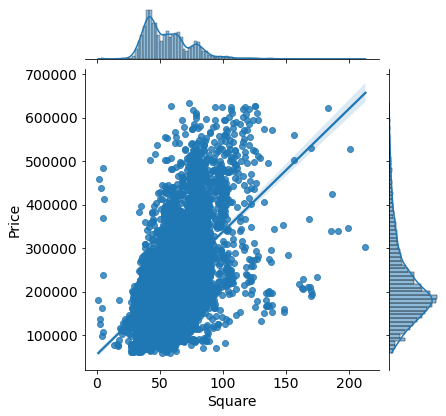

In [15]:
train_df.loc[train_df['Square'] < 500, 'Square'].hist(figsize=(5, 5), bins=40, grid=False)
plt.yscale('log')
train_df_square = train_df.loc[train_df['Square'] < 250]
grid = sns.jointplot(x=train_df_square['Square'], y=train_df_square['Price'], kind='reg')
plt.show()

Для признака Square ограничимся на минимальном значении 15 и максимальном 300.

**Rooms**

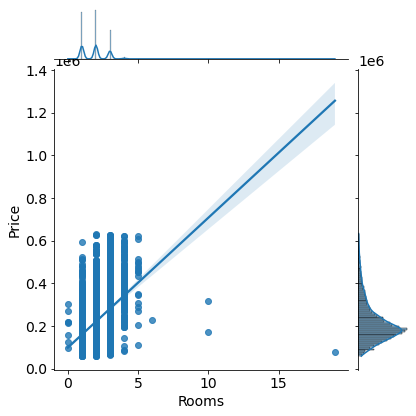

In [16]:
train_df_rooms = train_df.loc[train_df['Rooms'] < 250]
grid = sns.jointplot(x=train_df_rooms['Rooms'], y=train_df_rooms['Price'], kind='reg')
plt.show()

Ограничим Rooms от 1 до 5.

**Floor и HouseFlore**

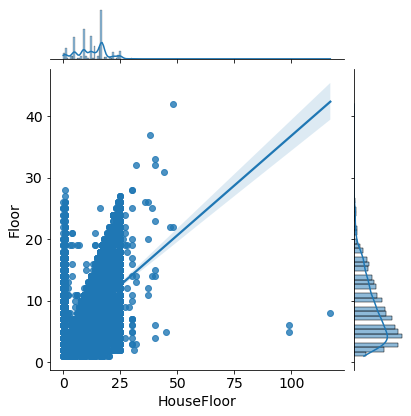

In [17]:
# train_df_square = train_df.loc[train_df['Square']<500]
grid = sns.jointplot(x=train_df['HouseFloor'], y=train_df['Floor'], kind='reg')
plt.show()

Есть номера этажей в домах больше, чем суммарное количество этажей. Исправим выбросы, ограничив HouseFloor от 1 до 50. А также исправим количество этажей в случае, если номер этажа больше, чем число этажей в доме: заменим число этажей на номер такого этажа.

**HouseYear**

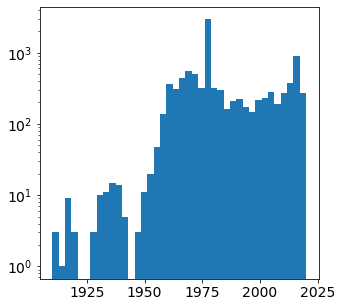

In [18]:
train_df.loc[train_df['HouseYear'] < 2022, 'HouseYear'].hist(figsize=(5, 5), bins=40, grid=False)
plt.yscale('log')
plt.show()

Судя по гистограмме выше и графиком с гистограммами всех количественных признаков, колонка HouseYear содержит опечатки. Заменим выбросы на текущий год. Затем заменим колонку на возраст дома в текущем году.

**Категориальные признаки**

In [19]:
categorial_features = train_df.select_dtypes(include='object').columns.tolist()
for categorial_feature in categorial_features:
    print(categorial_feature, train_df[categorial_feature].unique())

Ecology_2 ['B' 'A']
Ecology_3 ['B' 'A']
Shops_2 ['B' 'A']


Категориальные признаки можно бинаризовать.

**Матрица корреляций**

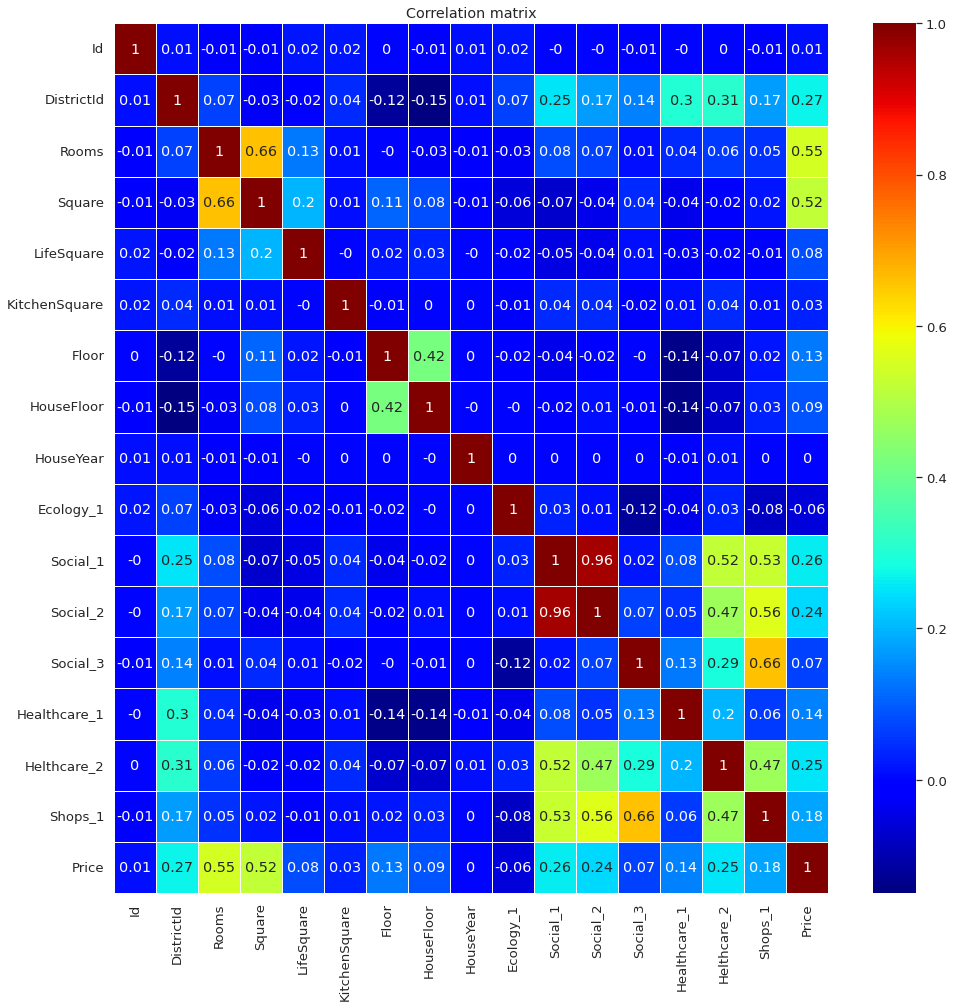

In [20]:
plt.figure(figsize = (16, 16))
sns.set(font_scale=1.2)
correlation_matrix = train_df.corr()
correlation_matrix = np.round(correlation_matrix, 2)
sns.heatmap(correlation_matrix, annot=True, linewidths=1, cmap='jet')
plt.title('Correlation matrix')
plt.show()

**Пропуски**

In [21]:
is_na_set = train_df.isna().sum()
columns_without_na = is_na_set[is_na_set == 0]
is_na_set

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Заполнение LifeSquare**

LifeSquare имеет достаточно много пропусков, и, с другой стороны, как исходя из здравого смысла, так и корреляции с целевой переменной, является важным признаком. Пропуски в нем следует заполнять аккуратно.
Возьмем наиболее скоррелированные признаки (исключая целевую) и заполним пропуски с использованием MICE.

**Построение новых признаков**

1. Количество домов в районе DistrictHouses
2. Средняя цена за единицу площади в районе DistrictId
3. Средняя цена за комнату в районе DistrictId
5. Средний HealthCare_1 по району DistrictId (это поможет аккуратно обойти пропуски в колонке HealthCare_1)

In [22]:
print('Same DistrictId count in train and test:', train_df.merge(test_df, how='inner', on='DistrictId')['DistrictId'].unique().size)

Same DistrictId count in train and test: 194


В тесте и трейне есть одинаковые номера районов. Цена коррелирует с номером района (что видно из матрицы корреляции). Часто расположение дома сильно влияет на цены квартир. Если составить признак, прямо связанный с ценой, это улучшит обучение модели, а также увеличит точность предсказаний на тестовом датасете.

**HealthCare_1**

Данный признак содержит почти половину пропусков, попробуем заменить его на среднее значение по району и заполнить оставшееся с помощью MICE.

**Класс для подготовки данных**

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model


class DataProcessing:
    def __init__(self):
        # Значения для обработки выбросов:
        self.kitchensquare_min = 0
        self.kitchensquare_max = 28
        self.lifesquare_min = 10
        self.lifesquare_max = 275
        self.square_min = 15
        self.square_max = 300
        self.rooms_min = 1
        self.rooms_max = 5
        self.housefloor_min = 1
        self.housefloor_max = 50
        self.year = datetime.now().year
        # Словарь для бинаризации категориальных признаков:
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # Временные датасеты для создания новых признаков:
        self.district_houses = None
        self.district_mean_square_price = None
        self.district_mean_healthcare_1 = None
        self.district_mean_room_price = None


    def _fill_na_using_mice(self, X, columns, target_column):
        X_mice = X.filter(columns, axis=1).copy()
        mice_imp = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
        X_mice_imputed = pd.DataFrame(mice_imp.fit_transform(X_mice), columns=X_mice.columns)
        return X_mice_imputed[target_column]


    def fit(self, X, y=None):
        X = X.copy()
        # Количество домов в районе:
        self.district_houses = X.DistrictId.value_counts().reset_index().rename(
            columns={'index': 'DistrictId', 'DistrictId': 'DistrictHouses'})
        # Средняя цена за единицу площади по району:
        X_temp = X.loc[(X['Square'] > self.square_min)&(X['Square'] < self.square_max)]
        X_temp['SquarePrice'] = X_temp['Price'] / X_temp['Square']
        district_id_groupby = X_temp[['DistrictId', 'SquarePrice']].groupby('DistrictId', as_index=False)
        self.district_mean_square_price = district_id_groupby.agg(
            {'SquarePrice': 'mean'}).rename(columns={'SquarePrice': 'DistrictMeanSquarePrice'})
        # Средняя цена за комнату по району:
        X_temp['RoomPrice'] = X_temp['Price'] / X_temp['Rooms']
        rdistrict_id_groupby = X_temp[['DistrictId', 'RoomPrice']].groupby('DistrictId', as_index=False)
        self.district_mean_room_price = rdistrict_id_groupby.agg(
            {'RoomPrice': 'mean'}).rename(columns={'RoomPrice': 'DistrictMeanRoomPrice'})
        # Средний показатель Healthcare_1 по району:
        if 'Healthcare_1' in X_temp.columns:
            hdistrict_id_groupby = X_temp[['DistrictId', 'Healthcare_1']].groupby('DistrictId', as_index=False)
            self.district_mean_healthcare_1 = hdistrict_id_groupby.agg(
                {'Healthcare_1': 'mean'}).rename(columns={'Healthcare_1': 'DistrictMeanHealthcare_1'})
        del X_temp
        

    def transform(self, X):
        # Выбросы:
        X.loc[X['KitchenSquare'] > self.kitchensquare_max, 'KitchenSquare'] = self.kitchensquare_max
        X.loc[X['KitchenSquare'] < self.kitchensquare_min, 'KitchenSquare'] = self.kitchensquare_min
        X.loc[X['LifeSquare'] > self.lifesquare_max, 'LifeSquare'] = self.lifesquare_max
        X.loc[X['LifeSquare'] < self.lifesquare_min, 'LifeSquare'] = self.lifesquare_min
        X.loc[X['Square'] > self.square_max, 'Square'] = self.square_max
        X.loc[X['Square'] < self.square_min, 'Square'] = self.square_min
        X.loc[X['Rooms'] > self.rooms_max, 'Square'] = self.rooms_max
        X.loc[X['Rooms'] < self.rooms_min, 'Square'] = self.rooms_min
        X.loc[X['HouseFloor'] > self.housefloor_max, 'HouseFloor'] = self.housefloor_max
        X.loc[X['HouseFloor'] < self.housefloor_min, 'HouseFloor'] = self.housefloor_min
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = X.loc[X['Floor'] > X['HouseFloor'], 'Floor']
        if 'HouseYear' in X.columns.tolist():
            X.loc[X['HouseYear'] > self.year, 'HouseYear'] = self.year
        # Категориальные признаки в дамми-переменные:
        X = X.replace(self.binary_to_numbers)
        # Пропуски в LifeSquare:
        X['LifeSquare'] = self._fill_na_using_mice(X, ['Square', 'Rooms', 'LifeSquare'], 'LifeSquare')
        return X


    def add_features(self, X):
        x_columns = X.columns.tolist()
        # Создание признака с возрастом дома:
        if 'HouseYear' in x_columns:
            X['HouseAge'] = self.year - X['HouseYear']
        # Создание признака, содержащего количество домов в районе:
        if 'DistrictHouses' not in x_columns:
            X = X.merge(self.district_houses, on='DistrictId', how='left')
            if X['DistrictHouses'].isna().any():
                X['DistrictHouses'] = self._fill_na_using_mice(
                    X, ['DistrictId', 'Social_1', 'DistrictHouses'], 'DistrictHouses')
        # Создание признака, содержащего среднюю цену за единицу площади по району:
        if 'DistrictMeanSquarePrice' not in x_columns:
            X = X.merge(self.district_mean_square_price, on='DistrictId', how='left')
            if X['DistrictMeanSquarePrice'].isna().any():
                X['DistrictMeanSquarePrice'] = self._fill_na_using_mice(
                    X, ['DistrictId', 'Square', 'Rooms', 'LifeSquare', 'DistrictMeanSquarePrice'], 'DistrictMeanSquarePrice')
        # Создание признака, содержащего среднюю цену за комнату по району:
        if 'DistrictMeanRoomPrice' not in x_columns:
            X = X.merge(self.district_mean_room_price, on='DistrictId', how='left')
            if X['DistrictMeanRoomPrice'].isna().any():
                X['DistrictMeanRoomPrice'] = self._fill_na_using_mice(
                    X, ['DistrictId', 'Square', 'Rooms', 'LifeSquare', 'DistrictMeanRoomPrice'], 'DistrictMeanRoomPrice')
        # Создание признака, содержащего среднее значение Healthcare_1 по району:
        if 'DistrictMeanHealthcare_1' not in x_columns:
            if self.district_mean_healthcare_1['DistrictMeanHealthcare_1'].isna().any():
                self.district_mean_healthcare_1['DistrictMeanHealthcare_1'] = self._fill_na_using_mice(
                    self.district_mean_healthcare_1, ['DistrictId', 'DistrictMeanSquarePrice', 
                    'Helthcare_2', 'DistrictMeanHealthcare_1'], 'DistrictMeanHealthcare_1')
            X = X.merge(self.district_mean_healthcare_1, on='DistrictId', how='left')
            if X['DistrictMeanHealthcare_1'].isna().any():
                X['DistrictMeanHealthcare_1'] = self._fill_na_using_mice(
                    X, ['DistrictId', 'DistrictMeanSquarePrice', 'Helthcare_2', 'Social_3',
                    'DistrictMeanHealthcare_1'], 'DistrictMeanHealthcare_1')
        # Удаление лишних признаков:
        columns_to_drop = ['Healthcare_1', 'HouseYear']
        to_remove = []
        for column in columns_to_drop:
            if column not in x_columns:
                to_remove.append(column)
        for tr in to_remove:
            columns_to_drop.remove(tr)
        X = X.drop(columns=columns_to_drop)
        return X

    
    def get_feature_names(self, X, target):
        return X.columns[(X.columns != target)&(X.columns != 'Id')]
        

**Разбиение тренировочных данных и выбор модели**

In [24]:
data_processing = DataProcessing()
data_processing.fit(train_df)
train_df = data_processing.transform(train_df)
train_df = data_processing.add_features(train_df)
target = 'Price'
x_columns = data_processing.get_feature_names(train_df, target)

Разбиение тренировочных данных для подбора гиперпараметров модели

In [25]:
X, y = train_df[x_columns], train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

Подбор гиперпараметров модели

In [26]:
# parameters = {'iterations': [950, 960, 970, 980, 990, 1000], 'learning_rate': [0.04, 0.05, 0.06], 'depth': [7, 8, 9], 'l2_leaf_reg': [0.45, 0.5, 0.55]}
# ctbreg_model = GridSearchCV(estimator=CatBoostRegressor(silent=True), param_grid=parameters, scoring='r2', cv=3, verbose=1)
# ctbreg_model.fit(X_train, y_train)
# print(ctbreg_model.best_estimator_.get_params())
# y_train_preds = ctbreg_model.predict(X_train)
# y_test_preds = ctbreg_model.predict(X_test)
# features_importances = pd.Series(ctbreg_model.best_estimator_.feature_importances_, index=ctbreg_model.best_estimator_.feature_names_)
# print('Важность признаков:')
# print(features_importances.sort_values()[::-1])
# evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Обучение на тренировочном датасете

In [27]:
ctbreg_final_model = CatBoostRegressor(silent=True, learning_rate=0.05, iterations=960, l2_leaf_reg=0.5, depth=8) # best
ctbreg_final_model.fit(X, y)

Кросс-валидация

In [28]:
cross_val = cross_val_score(ctbreg_final_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
print(cross_val.mean())

0.762825094691661


**Работа с тестовым датасетом**

In [29]:
test_df_copy = test_df[['Id']].copy()

In [30]:
test_df = data_processing.transform(test_df)
test_df = data_processing.add_features(test_df)

**Предсказания на тестовом датасете**

In [31]:
test_df = test_df[x_columns]
y_pred_final = ctbreg_final_model.predict(test_df)

Сохранение для сабмита

In [32]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(columns=['Price'])
test_df_copy['Price'] = y_pred_final
submission_df = submission_df.merge(test_df_copy[['Id', 'Price']], on='Id', how='left')
submission_df.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')

Kaggle **R2**

![PIC](submission_score.png)